# `Lead Scoring Case Study`
*With close to 35 predictor variables we need to select the most promising leads, i.e. the leads that are most likely to convert into paying customers for education company X Education which sells online courses to industry professionals. The company requires us to build a model wherein we need to assign a lead score to each of the leads such that the customers with higher lead score have a higher conversion chance and the customers with lower lead score have a lower conversion chance.*

## Step 1: Importing import packages and Reading Data

In [6]:
# Importing all required packages
import numpy as np
import pandas as pd
from datetime import datetime as dt

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import scale

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pandas as pd

ImportError: cannot import name 'fetch_mldata' from 'sklearn.datasets' (C:\Users\anshu\anaconda3\Annaconda\lib\site-packages\sklearn\datasets\__init__.py)

In [ ]:
#reading Dataset
leads = pd.read_csv(r"C:\Users\anshu\OneDrive\Documents\BA Assignment\Lead+Scoring+Case+Study (1)\Lead Scoring Assignment\Leads.csv")
leads.head()

## Step 2: Inspecting the Dataframe

In [ ]:
leads.dtypes

In [ ]:
leads.shape

## Step 3: Data Preparation

### Handling Duplicate Rows

In [7]:
# removing duplicate rows
leads.drop_duplicates(subset='Lead Number')
leads.shape

(9240, 37)

### Handling Null Values

In [8]:
# Checking for total count and percentage of null values in all columns of the dataframe.

total = pd.DataFrame(leads.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(leads.isnull().sum()/leads.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])
pd.concat([total, percentage], axis = 1)

,Total,Percentage
Lead Quality,4767,51.59
Asymmetrique Activity Index,4218,45.65
Asymmetrique Profile Score,4218,45.65
Asymmetrique Activity Score,4218,45.65
Asymmetrique Profile Index,4218,45.65
Tags,3353,36.29
Lead Profile,2709,29.32
What matters most to you in choosing a course,2709,29.32
What is your current occupation,2690,29.11
Country,2461,26.63


### *Visualizing occurence of Null values in the columns based on rows*

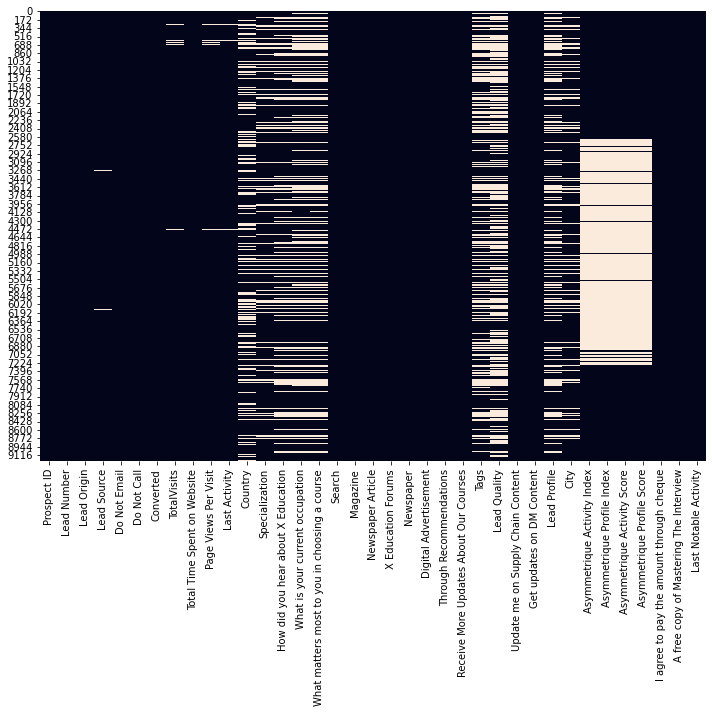

In [9]:
plt.figure(figsize=(10,10))
sns.heatmap(leads.isnull(), cbar=False)

plt.tight_layout()
plt.show()

### Dropping Unnecessary Columns NOT needed for Analysis

In [10]:
# Identifying if any column exists with only null values
leads.isnull().all(axis=0).any()

False

In [11]:
# Dropping all columns with only 0 values
leads.loc[:, (leads != 0).any(axis=0)]
leads.shape

(9240, 37)

In [12]:
#Remove columns which has only one unique value

"""
Deleting the following columns as they have only one unique value and hence cannot be responsible in predicting a successful lead case

Magazine
Receive More Updates About Our Courses
Update me on Supply Chain Content
Update me on Supply Chain Content
I agree to pay the amount through cheque

"""   
leads= leads.loc[:,leads.nunique()!=1]
leads.shape

(9240, 32)

In [13]:
# Deleting the columns 'Asymmetrique Activity Score' & 'Asymmetrique Profile Score' 
# as they will be represented by their corresponding index columns
leads = leads.drop('Asymmetrique Activity Score', axis=1)
leads = leads.drop('Asymmetrique Profile Score', axis=1)
leads.shape

(9240, 30)

In [14]:
# Deleting the columns 'Prospect ID' as it will not have any effect in the predicting model
leads = leads.drop('Prospect ID', axis=1)
#leads = leads.drop('Lead Number', axis=1)
leads.shape

(9240, 29)

In [15]:
# Deleting the columns 'What matters most to you in choosing a course' as it mostly has unique values and some null values.
leads = leads.drop('What matters most to you in choosing a course', axis=1)
leads.shape

(9240, 28)

In [16]:
# Deleting the columns 'How did you hear about X Education' as it mostly has null values or 'Select' values 
# that contribute to the 'Converted' percentage.
leads = leads.drop('How did you hear about X Education', axis=1)
leads.shape

(9240, 27)

### Removing rows where a particular column has high missing values

In [17]:
leads['Lead Source'].isnull().sum()

36

In [18]:
# removing rows where a particular column has high missing values because the column cannot be removed because of its importance
leads = leads[~pd.isnull(leads['Lead Source'])]
leads.shape

(9204, 27)

### Imputing with Median values because the continuous variables have outliers

In [19]:
leads['TotalVisits'].replace(np.NaN, leads['TotalVisits'].median(), inplace =True)

In [20]:
leads['Page Views Per Visit'].replace(np.NaN, leads['Page Views Per Visit'].median(), inplace =True)

### Imputing with Mode values

In [21]:
    leads['Country'].mode()

0    India
dtype: object

In [22]:
leads.loc[pd.isnull(leads['Country']), ['Country']] = 'India'

In [23]:
leads['Country'] = leads['Country'].apply(lambda x: 'India' if x=='India' else 'Outside India')
leads['Country'].value_counts()

India            8917
Outside India     287
Name: Country, dtype: int64

<AxesSubplot:xlabel='Converted', ylabel='Country'>

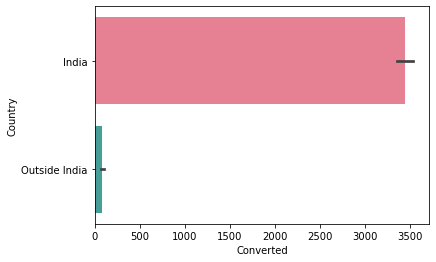

In [24]:
sns.barplot(y='Country', x='Converted', palette='husl', data=leads, estimator=np.sum)

### Assigning An Unique Category to NULL/SELECT values

#### Instead of deleting columns with huge null value percentage(which results in loss of data), this strategy adds more information into the dataset and results in the change of variance.

***Creating a new category consisting on NULL/Select values for the field `Lead Quality`***

### `'Select' values in some columns` : 

#### There are some columns in dataset which have a level/value called 'Select'. This might have happened because these fields in the website might be non mandatory fields with drop downs options for the customer to choose from. Amongst the dropdown values, the default option is probably 'Select' and since these aren't  mandatory fields, many customer might have have chosen to leave it as the default value 'Select'.

In [25]:
leads['Lead Quality'].value_counts()

Might be             1545
Not Sure             1090
High in Relevance     632
Worst                 601
Low in Relevance      583
Name: Lead Quality, dtype: int64

In [26]:
leads['Lead Quality'].isnull().sum()

4753

In [27]:
leads['Lead Quality'].fillna("Unknown", inplace = True)
leads['Lead Quality'].value_counts()

Unknown              4753
Might be             1545
Not Sure             1090
High in Relevance     632
Worst                 601
Low in Relevance      583
Name: Lead Quality, dtype: int64

<AxesSubplot:xlabel='Converted', ylabel='Lead Quality'>

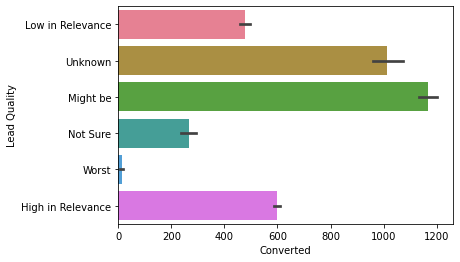

In [28]:
sns.barplot(y='Lead Quality', x='Converted', palette='husl', data=leads, estimator=np.sum)

***Creating a new category consisting on NULL/Select values for the field `Asymmetrique Profile Index`***

In [29]:
leads['Asymmetrique Profile Index'].value_counts()

02.Medium    2771
01.High      2201
03.Low         31
Name: Asymmetrique Profile Index, dtype: int64

In [30]:
leads['Asymmetrique Profile Index'].isnull().sum()

4201

In [31]:
leads['Asymmetrique Profile Index'].fillna("Unknown", inplace = True)
leads['Asymmetrique Profile Index'].value_counts()

Unknown      4201
02.Medium    2771
01.High      2201
03.Low         31
Name: Asymmetrique Profile Index, dtype: int64

<AxesSubplot:xlabel='Converted', ylabel='Asymmetrique Profile Index'>

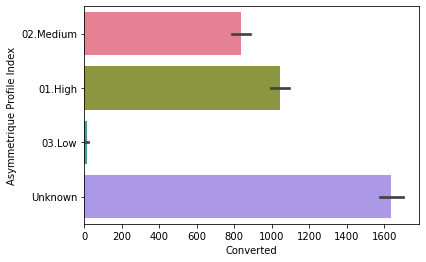

In [32]:
sns.barplot(y='Asymmetrique Profile Index', x='Converted', palette='husl', data=leads, estimator=np.sum)

***Creating a new category consisting on NULL/Select values for the field `Asymmetrique Activity Index`***

In [33]:
leads['Asymmetrique Activity Index'].value_counts()

02.Medium    3820
01.High       821
03.Low        362
Name: Asymmetrique Activity Index, dtype: int64

In [34]:
leads['Asymmetrique Activity Index'].isnull().sum()

4201

In [35]:
leads['Asymmetrique Activity Index'].fillna("Unknown", inplace = True)
leads['Asymmetrique Activity Index'].value_counts()

Unknown      4201
02.Medium    3820
01.High       821
03.Low        362
Name: Asymmetrique Activity Index, dtype: int64

<AxesSubplot:xlabel='Converted', ylabel='Asymmetrique Activity Index'>

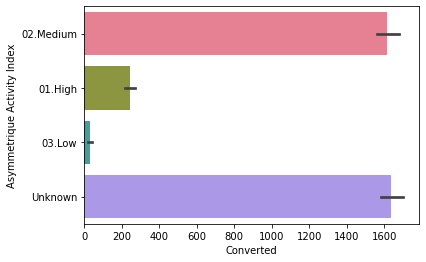

In [36]:
sns.barplot(y='Asymmetrique Activity Index', x='Converted', palette='husl', data=leads, estimator=np.sum)

***Creating a new category consisting on NULL/Select values for the field `City`***

In [37]:
leads['City'].isnull().sum()

1420

In [38]:
leads['City'].fillna("Unknown", inplace = True)
leads['City'].value_counts()

Mumbai                         3220
Select                         2218
Unknown                        1420
Thane & Outskirts               751
Other Cities                    686
Other Cities of Maharashtra     456
Other Metro Cities              379
Tier II Cities                   74
Name: City, dtype: int64

In [39]:
leads['City'].replace('Select', 'Unknown', inplace =True)
leads['City'].value_counts()

Unknown                        3638
Mumbai                         3220
Thane & Outskirts               751
Other Cities                    686
Other Cities of Maharashtra     456
Other Metro Cities              379
Tier II Cities                   74
Name: City, dtype: int64

<AxesSubplot:xlabel='Converted', ylabel='City'>

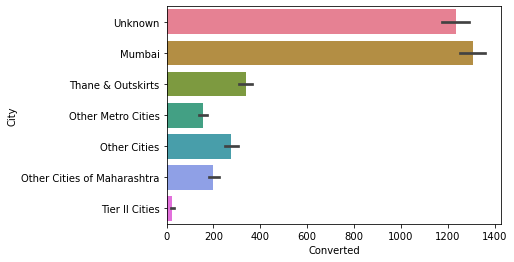

In [40]:
sns.barplot(y='City', x='Converted', palette='husl', data=leads, estimator=np.sum)

***Creating a new category consisting on NULL/Select values for the field `Last Activity`***

In [41]:
leads['Last Activity'].value_counts()

Email Opened                    3432
SMS Sent                        2723
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    321
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       93
Unsubscribed                      59
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Received                     2
Email Marked Spam                  2
Visited Booth in Tradeshow         1
Resubscribed to emails             1
Name: Last Activity, dtype: int64

In [42]:
leads['Last Activity'].isnull().sum()

101

In [43]:
leads['Last Activity'].fillna("Unknown", inplace = True)
leads['Last Activity'].value_counts()

Email Opened                    3432
SMS Sent                        2723
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    321
Email Link Clicked               267
Form Submitted on Website        116
Unknown                          101
Unreachable                       93
Unsubscribed                      59
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Received                     2
Email Marked Spam                  2
Visited Booth in Tradeshow         1
Resubscribed to emails             1
Name: Last Activity, dtype: int64

<AxesSubplot:xlabel='Converted', ylabel='Last Activity'>

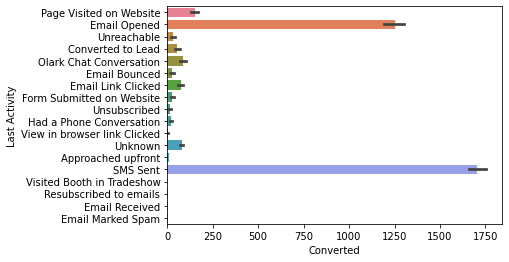

In [44]:
sns.barplot(y='Last Activity', x='Converted', palette='husl', data=leads, estimator=np.sum)

***Creating a new category consisting on NULL/Select values for the field `Lead Profile`***

In [45]:
leads['Lead Profile'].value_counts()

Select                         4115
Potential Lead                 1608
Other Leads                     487
Student of SomeSchool           241
Lateral Student                  24
Dual Specialization Student      20
Name: Lead Profile, dtype: int64

In [46]:
leads['Lead Profile'].isnull().sum()

2709

In [47]:
leads['Lead Profile'].fillna("Unknown", inplace = True)
leads['Lead Profile'].value_counts()

Select                         4115
Unknown                        2709
Potential Lead                 1608
Other Leads                     487
Student of SomeSchool           241
Lateral Student                  24
Dual Specialization Student      20
Name: Lead Profile, dtype: int64

In [48]:
leads['Lead Profile'].replace('Select', 'Unknown', inplace =True)
leads['Lead Profile'].value_counts()

Unknown                        6824
Potential Lead                 1608
Other Leads                     487
Student of SomeSchool           241
Lateral Student                  24
Dual Specialization Student      20
Name: Lead Profile, dtype: int64

<AxesSubplot:xlabel='Converted', ylabel='Lead Profile'>

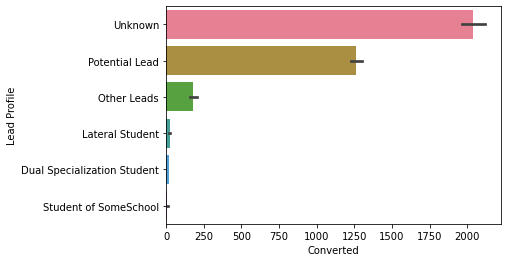

In [49]:
sns.barplot(y='Lead Profile', x='Converted', palette='husl', data=leads, estimator=np.sum)

***Creating a new category consisting on NULL/Select values for the field `What is your current occupation`***

In [50]:
leads['What is your current occupation'].value_counts()

Unemployed              5567
Working Professional     704
Student                  209
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

In [51]:
leads['What is your current occupation'].isnull().sum()

2690

In [52]:
leads['What is your current occupation'].fillna("Unknown", inplace = True)
leads['What is your current occupation'].value_counts()

Unemployed              5567
Unknown                 2690
Working Professional     704
Student                  209
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

<AxesSubplot:xlabel='Converted', ylabel='What is your current occupation'>

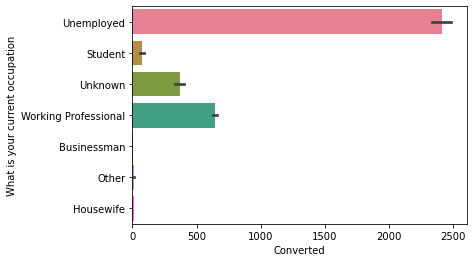

In [53]:
sns.barplot(y='What is your current occupation', x='Converted', palette='husl', data=leads, estimator=np.sum)

***Creating a new category consisting on NULL/Select values for the field `Specialization`***

In [54]:
leads['Specialization'].value_counts()

Select                               1914
Finance Management                    973
Human Resource Management             847
Marketing Management                  837
Operations Management                 502
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Travel and Tourism                    203
Media and Advertising                 203
International Business                178
Healthcare Management                 158
Hospitality Management                114
E-COMMERCE                            111
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: Specialization, dtype: int64

In [55]:
leads['Specialization'].isnull().sum()

1438

In [56]:
leads['Specialization'].fillna("Unknown", inplace = True)
leads['Specialization'].value_counts()

Select                               1914
Unknown                              1438
Finance Management                    973
Human Resource Management             847
Marketing Management                  837
Operations Management                 502
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Travel and Tourism                    203
Media and Advertising                 203
International Business                178
Healthcare Management                 158
Hospitality Management                114
E-COMMERCE                            111
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: Specialization, dtype: int64

<AxesSubplot:xlabel='Converted', ylabel='Specialization'>

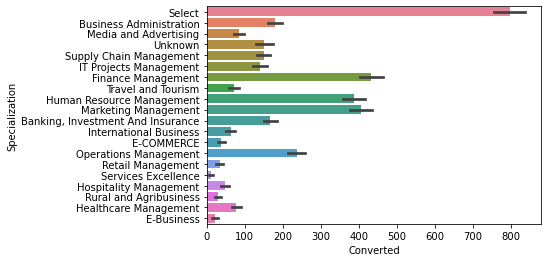

In [57]:
sns.barplot(y='Specialization', x='Converted', palette='husl', data=leads, estimator=np.sum)

***Creating a new category consisting on NULL/Select values for the field `Tags`***

In [58]:
leads['Tags'].value_counts()

Will revert after reading the email                  2052
Ringing                                              1200
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          174
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    26
in touch with EINS                                     12
Lost to Others

In [59]:
leads['Tags'].isnull().sum()

3342

In [60]:
leads['Tags'].fillna("Unknown", inplace = True)
leads['Tags'].value_counts()

Unknown                                              3342
Will revert after reading the email                  2052
Ringing                                              1200
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          174
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    26
in touch with 

<AxesSubplot:xlabel='Converted', ylabel='Tags'>

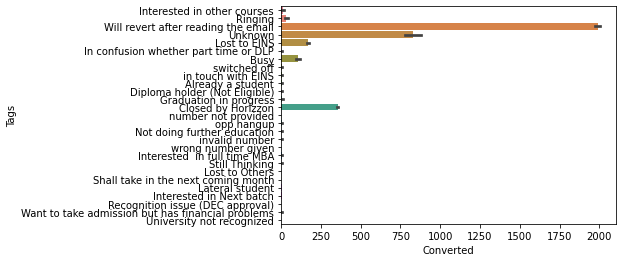

In [61]:
sns.barplot(y='Tags', x='Converted', palette='husl', data=leads, estimator=np.sum)

## Reinspecting Null Values

In [62]:
# Checking for total count and percentage of null values in all columns of the dataframe.

total = pd.DataFrame(leads.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(leads.isnull().sum()/leads.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])
pd.concat([total, percentage], axis = 1).head()

,Total,Percentage
Lead Number,0,0.0
Newspaper Article,0,0.0
A free copy of Mastering The Interview,0,0.0
Asymmetrique Profile Index,0,0.0
Asymmetrique Activity Index,0,0.0


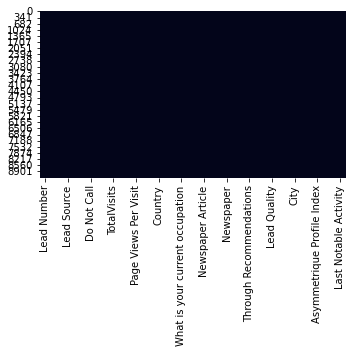

In [63]:
plt.figure(figsize=(5,5))
sns.heatmap(leads.isnull(), cbar=False)

plt.tight_layout()
plt.show()

### Checking for Outliers

In [64]:
# Checking outliers at 25%,50%,75%,90%,95% and 99%
leads.describe(percentiles=[.25,.5,.75,.90,.95,.99]).T

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
Lead Number,9204.0,617194.608648,23418.830233,579533.0,596484.5,615479.0,637409.25,650513.1,655405.85,659599.46,660737.0
Converted,9204.0,0.383746,0.486324,0.0,0.0,0.0,1.00,1.0,1.00,1.00,1.0
TotalVisits,9204.0,3.449587,4.824662,0.0,1.0,3.0,5.00,7.0,10.00,17.00,251.0
Total Time Spent on Website,9204.0,489.005541,547.980340,0.0,14.0,250.0,938.00,1380.0,1562.00,1839.97,2272.0
Page Views Per Visit,9204.0,2.364923,2.145999,0.0,1.0,2.0,3.00,5.0,6.00,9.00,55.0


In [65]:
numeric_variables = ['TotalVisits','Total Time Spent on Website','Page Views Per Visit']
print(numeric_variables)

['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']


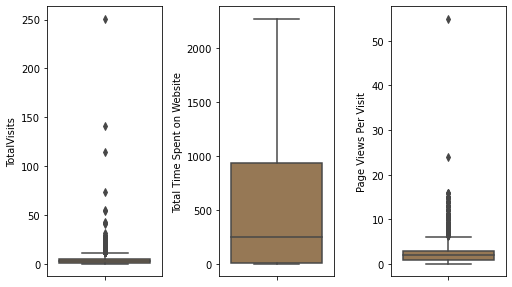

In [66]:
numeric_variables = ['TotalVisits','Total Time Spent on Website','Page Views Per Visit']

#Function to plot the distribution plot of the numeric variable list
def boxplot(var_list):
    plt.figure(figsize=(12,8))
    for var in var_list:
        plt.subplot(2,5,var_list.index(var)+1)
        #plt.boxplot(country[var])
        sns.boxplot(y=var,palette='cubehelix', data=leads)
    # Automatically adjust subplot params so that the subplotS fits in to the figure area.
    plt.tight_layout()
    # display the plot
    plt.show()
    
boxplot(numeric_variables)    

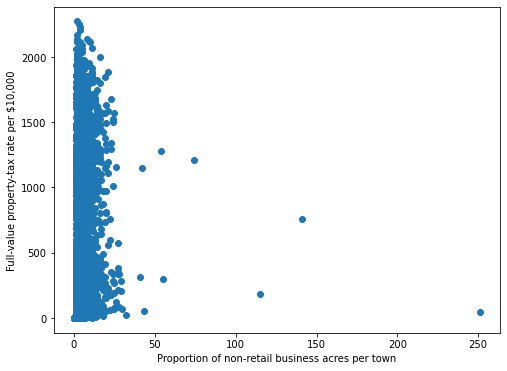

In [67]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(leads['TotalVisits'], leads['Total Time Spent on Website'])
ax.set_xlabel('Proportion of non-retail business acres per town')
ax.set_ylabel('Full-value property-tax rate per $10,000')
plt.show()

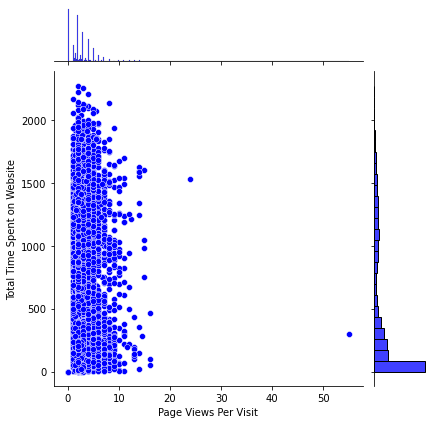

In [68]:
sns.jointplot(leads['Page Views Per Visit'],leads['Total Time Spent on Website'], color="b")
plt.show()

### Removing outlier values based on the Interquartile distance for some of the continuous variable

In [69]:
Q1 = leads['TotalVisits'].quantile(0.25)
Q3 = leads['TotalVisits'].quantile(0.75)
IQR = Q3 - Q1
leads=leads.loc[(leads['TotalVisits'] >= Q1 - 1.5*IQR) & (leads['TotalVisits'] <= Q3 + 1.4*IQR)]

Q1 = leads['Page Views Per Visit'].quantile(0.25)
Q3 = leads['Page Views Per Visit'].quantile(0.75)
IQR = Q3 - Q1
leads=leads.loc[(leads['Page Views Per Visit'] >= Q1 - 1.5*IQR) & (leads['Page Views Per Visit'] <= Q3 + 1.5*IQR)]

leads.shape

(8575, 27)

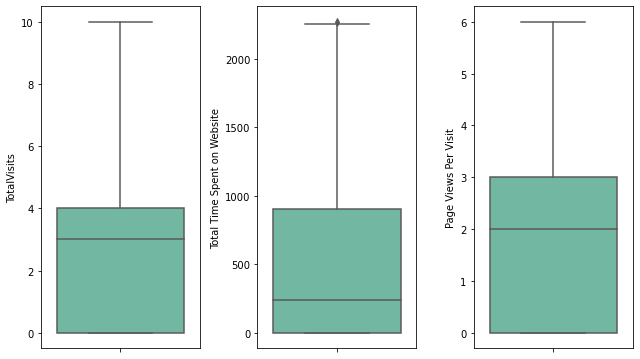

In [70]:
#Function to plot the distribution plot of the numeric variable list
def boxplot(var_list):
    plt.figure(figsize=(15,10))
    for var in var_list:
        plt.subplot(2,5,var_list.index(var)+1)
        #plt.boxplot(country[var])
        sns.boxplot(y=var,palette='BuGn_r', data=leads)
    # Automatically adjust subplot params so that the subplotS fits in to the figure area.
    plt.tight_layout()
    # display the plot
    plt.show()
    
boxplot(numeric_variables)    

In [71]:
leads.shape

(8575, 27)

### Converting some binary variables (Yes/No) to 0/1

In [72]:
# List of variables to map

varlist =  ['Search','Do Not Email', 'Do Not Call', 'Newspaper Article', 'X Education Forums', 'Newspaper', 
            'Digital Advertisement','Through Recommendations','A free copy of Mastering The Interview']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the housing list
leads[varlist] = leads[varlist].apply(binary_map)
leads.head()

,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,...,Digital Advertisement,Through Recommendations,Tags,Lead Quality,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,A free copy of Mastering The Interview,Last Notable Activity
0,660737,API,Olark Chat,0,0,0,0.0,0,0.0,Page Visited on Website,...,0,0,Interested in other courses,Low in Relevance,Unknown,Unknown,02.Medium,02.Medium,0,Modified
1,660728,API,Organic Search,0,0,0,5.0,674,2.5,Email Opened,...,0,0,Ringing,Unknown,Unknown,Unknown,02.Medium,02.Medium,0,Email Opened
2,660727,Landing Page Submission,Direct Traffic,0,0,1,2.0,1532,2.0,Email Opened,...,0,0,Will revert after reading the email,Might be,Potential Lead,Mumbai,02.Medium,01.High,1,Email Opened
3,660719,Landing Page Submission,Direct Traffic,0,0,0,1.0,305,1.0,Unreachable,...,0,0,Ringing,Not Sure,Unknown,Mumbai,02.Medium,01.High,0,Modified
4,660681,Landing Page Submission,Google,0,0,1,2.0,1428,1.0,Converted to Lead,...,0,0,Will revert after reading the email,Might be,Unknown,Mumbai,02.Medium,01.High,0,Modified


### For categorical variables with multiple levels, creating dummy features (one-hot encoded)

In [73]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy1 = pd.get_dummies(leads[['Country', 'Lead Source','Lead Origin','Last Notable Activity']], drop_first=True)

# Adding the results to the master dataframe
leads = pd.concat([leads, dummy1], axis=1)
leads.shape

(8575, 66)

In [74]:
# Creating dummy variables for the remaining categorical variables and 
# dropping the level called 'Unknown' which represents null/select values.

# Creating dummy variables for the variable 'Lead Quality'
ml = pd.get_dummies(leads['Lead Quality'], prefix='Lead Quality')
# Dropping the level called 'Unknown' which represents null/select values
ml1 = ml.drop(['Lead Quality_Unknown'], 1)
#Adding the results to the master dataframe
leads = pd.concat([leads,ml1], axis=1)
#--------------------------------------------------------------------------------------
# Creating dummy variables for the variable 'Asymmetrique Profile Index'
ml = pd.get_dummies(leads['Asymmetrique Profile Index'], prefix='Asymmetrique Profile Index')
# Dropping the level called 'Unknown' which represents null/select values
ml1 = ml.drop(['Asymmetrique Profile Index_Unknown'], 1)
#Adding the results to the master dataframe
leads = pd.concat([leads,ml1], axis=1)
#--------------------------------------------------------------------------------------
# Creating dummy variables for the variable 'Asymmetrique Activity Index'
ml = pd.get_dummies(leads['Asymmetrique Activity Index'], prefix='Asymmetrique Activity Index')
# Dropping the level called 'Unknown' which represents null/select values
ml1 = ml.drop(['Asymmetrique Activity Index_Unknown'], 1)
#Adding the results to the master dataframe
leads = pd.concat([leads,ml1], axis=1)
#--------------------------------------------------------------------------------------
# Creating dummy variables for the variable 'Tags'
ml = pd.get_dummies(leads['Tags'], prefix='Tags')
# Dropping the level called 'Unknown' which represents null/select values
ml1 = ml.drop(['Tags_Unknown'], 1)
#Adding the results to the master dataframe
leads = pd.concat([leads,ml1], axis=1)
#--------------------------------------------------------------------------------------
# Creating dummy variables for the variable 'Lead Profile'
ml = pd.get_dummies(leads['Lead Profile'], prefix='Lead Profile')
# Dropping the level called 'Unknown' which represents null/select values
ml1 = ml.drop(['Lead Profile_Unknown'], 1)
#Adding the results to the master dataframe
leads = pd.concat([leads,ml1], axis=1)
#--------------------------------------------------------------------------------------
# Creating dummy variables for the variable 'What is your current occupation'
ml = pd.get_dummies(leads['What is your current occupation'], prefix='What is your current occupation')
# Dropping the level called 'Unknown' which represents null/select values
ml1 = ml.drop(['What is your current occupation_Unknown'], 1)
#Adding the results to the master dataframe
leads = pd.concat([leads,ml1], axis=1)
#--------------------------------------------------------------------------------------
# Creating dummy variables for the variable 'Specialization'
ml = pd.get_dummies(leads['Specialization'], prefix='Specialization')
# Dropping the level called 'Unknown' which represents null/select values
ml1 = ml.drop(['Specialization_Unknown'], 1)
#Adding the results to the master dataframe
leads = pd.concat([leads,ml1], axis=1)
#--------------------------------------------------------------------------------------
# Creating dummy variables for the variable 'City'
ml = pd.get_dummies(leads['City'], prefix='City')
# Dropping the level called 'Unknown' which represents null/select values
ml1 = ml.drop(['City_Unknown'], 1)
#Adding the results to the master dataframe
leads = pd.concat([leads,ml1], axis=1)
#--------------------------------------------------------------------------------------
# Creating dummy variables for the variable 'Last Activity'
ml = pd.get_dummies(leads['Last Activity'], prefix='Last Activity')
# Dropping the level called 'Unknown' which represents null/select values
ml1 = ml.drop(['Last Activity_Unknown'], 1)
#Adding the results to the master dataframe
leads = pd.concat([leads,ml1], axis=1)
#--------------------------------------------------------------------------------------
leads.shape

(8575, 156)

### Dropping the repeated variables

In [75]:
# We have created dummies for the below variables, so we can drop them
leads = leads.drop(['Lead Quality','Asymmetrique Profile Index','Asymmetrique Activity Index','Tags','Lead Profile',
                    'Lead Origin','What is your current occupation', 'Specialization', 'City','Last Activity', 'Country', 
                    'Lead Source','Last Notable Activity'], 1)
leads.shape

(8575, 143)

In [76]:
leads.head()

,Lead Number,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Newspaper Article,X Education Forums,...,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow
0,660737,0,0,0,0.0,0,0.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,660728,0,0,0,5.0,674,2.5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,660727,0,0,1,2.0,1532,2.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,660719,0,0,0,1.0,305,1.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,660681,0,0,1,2.0,1428,1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
# Ensuring there are no categorical columns left in the dataframe
cols = leads.columns
num_cols = leads._get_numeric_data().columns
list(set(cols) - set(num_cols))

[]

In [78]:
# Creating a copy of this origial variable in case if needed later on
original_leads = leads.copy()
print(original_leads.shape)
print(leads.shape)

(8575, 143)
(8575, 143)


### Step 4: Test-Train Split

In [79]:
from sklearn.model_selection import train_test_split

In [80]:
# Putting feature variable to X
X = leads.drop(['Converted','Lead Number'], axis=1)

X.head()

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,...,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow
0,0,0,0.0,0,0.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,5.0,674,2.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2.0,1532,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1.0,305,1.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,2.0,1428,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
# Putting response variable to y
y = leads['Converted']

y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [82]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

## Step 5: Feature Scaling

In [83]:
from sklearn.preprocessing import StandardScaler

In [84]:
scaler = StandardScaler()

X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.fit_transform(X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])

X_train.head()

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,...,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow
8529,0,0,0.969969,-0.864724,1.785283,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7331,0,0,0.102087,-0.215257,0.562949,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7688,0,0,0.102087,1.523992,0.562949,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
92,0,0,0.536028,-0.686762,1.174116,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4908,0,0,-1.199737,-0.872062,-1.270553,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [85]:
X_train.describe()

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,...,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow
count,6002.000000,6002.0,6.002000e+03,6.002000e+03,6.002000e+03,6002.000000,6002.0,6002.0,6002.000000,6002.000000,...,6002.000000,6002.000000,6002.000000,6002.000000,6002.0,6002.000000,6002.000000,6002.000000,6002.000000,6002.000000
mean,0.076308,0.0,6.130088e-17,1.427826e-16,1.538996e-17,0.001000,0.0,0.0,0.000167,0.000333,...,0.014162,0.002499,0.111629,0.063146,0.0,0.298567,0.010163,0.007331,0.000333,0.000167
std,0.265512,0.0,1.000083e+00,1.000083e+00,1.000083e+00,0.031604,0.0,0.0,0.012908,0.018253,...,0.118168,0.049933,0.314936,0.243245,0.0,0.457668,0.100308,0.085313,0.018253,0.012908
min,0.000000,0.0,-1.199737e+00,-8.720622e-01,-1.270553e+00,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.0,-7.657957e-01,-8.683929e-01,-6.593854e-01,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.0,1.020868e-01,-4.381673e-01,-4.821826e-02,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.0,5.360281e-01,7.846274e-01,5.629489e-01,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.0,3.139676e+00,3.296264e+00,2.396450e+00,1.000000,0.0,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


### Checking the Lead Conversion Rate

In [86]:
### Checking the Lead Conversion Rate
converted = (sum(leads['Converted'])/len(leads['Converted'].index))*100
converted

38.04081632653061

We have almost 38% lead conversion rate

## Step 6: Model Building
Let's start by splitting our data into a training set and a test set.

#### Running Your First Training Model

In [87]:
import statsmodels.api as sm

In [88]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6002
Model:                            GLM   Df Residuals:                     5871
Model Family:                Binomial   Df Model:                          130
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 14 May 2023   Deviance:                       38131.
Time:                        22:38:30   Pearson chi2:                 1.86e+18
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
const                                                  -1.173e+14   1.08e+08  -1.08e+06      0.000   -1.17e+14   -1.17e+14
Do Not Email                                           -3.279e+14   4.66e+06  -7.03e+07      0.000   -3.28e+14   -3.28e+14
Do Not Call                                               -1.1655    4.8e-06  -2.43e+05      0.000      -1.166      -1.166
TotalVisits                                             6.249e+13   1.51e+06   4.13e+07      0.000    6.25e+13    6.25e+13
Total Time Spent on Website                             2.225e+14   1.07e+06   2.08e+08      0.000    2.23e+14    2.23e+14
Page Views Per Visit                                    -8.06e+13   1.64e+06  -4.92e+07      0.000   -8.06e+13   -8.06e+13
Search                                                  6.136e+14    2.9e+07   2.11e+07      0.000    6.14e+14    6.14e+14
Newspaper Article                                        115.4301   1.38e-06   8.36e+07      0.000     115.430     115.430
X Education Forums                                        77.2667   1.98e-06    3.9e+07      0.000      77.267      77.267
Newspaper                                              -4.698e+15   6.76e+07  -6.95e+07      0.000    -4.7e+15    -4.7e+15
Digital Advertisement                                  -2.816e+14   4.85e+07   -5.8e+06      0.000   -2.82e+14   -2.82e+14
Through Recommendations                                 6.519e+14      5e+07    1.3e+07      0.000    6.52e+14    6.52e+14
A free copy of Mastering The Interview                 -3.737e+13   2.94e+06  -1.27e+07      0.000   -3.74e+13   -3.74e+13
Country_Outside India                                   1.257e+14   4.99e+06   2.52e+07      0.000    1.26e+14    1.26e+14
Lead Source_Direct Traffic                              2.927e+15   7.95e+07   3.68e+07      0.000    2.93e+15    2.93e+15
Lead Source_Facebook                                    1.424e+15   4.01e+07   3.55e+07      0.000    1.42e+15    1.42e+15
Lead Source_Google                                      2.922e+15   7.95e+07   3.67e+07      0.000    2.92e+15    2.92e+15
Lead Source_Live Chat                                   5.259e+15   6.31e+07   8.33e+07      0.000    5.26e+15    5.26e+15
Lead Source_NC_EDM                                      7.025e+15   1.04e+08   6.74e+07      0.000    7.02e+15    7.02e+15
Lead Source_Olark Chat                                  3.118e+15   7.94e+07   3.93e+07      0.000    3.12e+15    3.12e+15
Lead Source_Organic Search                              2.783e+15   7.96e+07    3.5e+07      0.000    2.78e+15    2.78e+15
Lead Source_Pay per Click Ads                          -2.382e+14   1.04e+08  -2.28e+06      0.000   -2.38e+14   -2.38e+14
Lead Sou

## Step 7: Feature Selection Using RFE

In [89]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [90]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 20)             # running RFE with 20 variables as output
rfe = rfe.fit(X_train, y_train)

In [91]:
rfe.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True,  True,
       False,  True,  True, False, False,  True, False,  True, False,
        True, False,  True, False,  True, False, False, False, False,
        True, False,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [92]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Do Not Email', False, 8),
 ('Do Not Call', False, 122),
 ('TotalVisits', False, 73),
 ('Total Time Spent on Website', False, 12),
 ('Page Views Per Visit', False, 55),
 ('Search', False, 24),
 ('Newspaper Article', False, 116),
 ('X Education Forums', False, 115),
 ('Newspaper', False, 91),
 ('Digital Advertisement', False, 89),
 ('Through Recommendations', False, 102),
 ('A free copy of Mastering The Interview', False, 90),
 ('Country_Outside India', False, 78),
 ('Lead Source_Direct Traffic', False, 53),
 ('Lead Source_Facebook', False, 54),
 ('Lead Source_Google', False, 94),
 ('Lead Source_Live Chat', False, 110),
 ('Lead Source_NC_EDM', False, 16),
 ('Lead Source_Olark Chat', False, 11),
 ('Lead Source_Organic Search', False, 70),
 ('Lead Source_Pay per Click Ads', False, 111),
 ('Lead Source_Press_Release', False, 120),
 ('Lead Source_Reference', False, 35),
 ('Lead Source_Referral Sites', False, 63),
 ('Lead Source_Social Media', False, 114),
 ('Lead Source_WeLearn', False, 1

In [93]:
col = X_train.columns[rfe.support_]
col

Index(['Lead Source_Welingak Website', 'Lead Quality_Worst',
       'Asymmetrique Activity Index_03.Low', 'Tags_Already a student',
       'Tags_Closed by Horizzon', 'Tags_Diploma holder (Not Eligible)',
       'Tags_Interested  in full time MBA', 'Tags_Interested in other courses',
       'Tags_Lost to EINS', 'Tags_Not doing further education', 'Tags_Ringing',
       'Tags_Will revert after reading the email', 'Tags_invalid number',
       'Tags_number not provided', 'Tags_opp hangup', 'Tags_switched off',
       'Tags_wrong number given', 'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional',
       'Last Activity_SMS Sent'],
      dtype='object')

In [94]:
X_train.columns[~rfe.support_]

Index(['Do Not Email', 'Do Not Call', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Search',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement',
       ...
       'Last Activity_Email Received',
       'Last Activity_Form Submitted on Website',
       'Last Activity_Had a Phone Conversation',
       'Last Activity_Olark Chat Conversation',
       'Last Activity_Page Visited on Website',
       'Last Activity_Resubscribed to emails', 'Last Activity_Unreachable',
       'Last Activity_Unsubscribed',
       'Last Activity_View in browser link Clicked',
       'Last Activity_Visited Booth in Tradeshow'],
      dtype='object', length=121)

##### Assessing the model with StatsModels

In [95]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6002
Model:                            GLM   Df Residuals:                     5981
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1264.7
Date:                Sun, 14 May 2023   Deviance:                       2529.4
Time:                        22:40:04   Pearson chi2:                 8.56e+03
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.4929      0.090    -27.836      0.000      -2.668      -2.317
Lead Source_Welingak Website                             3.2281      0.731      4.414      0.000       1.795       4.662
Lead Quality_Worst                                      -2.5504      0.761     -3.354      0.001      -4.041      -1.060
Asymmetrique Activity Index_03.Low                      -2.4592      0.358     -6.869      0.000      -3.161      -1.758
Tags_Already a student                                  -3.8785      0.726     -5.344      0.000      -5.301      -2.456
Tags_Closed by Horizzon                                  5.1421      0.722      7.120      0.000       3.727       6.558
Tags_Diploma holder (Not Eligible)                     -24.1871   2.82e+04     -0.001      0.999   -5.52e+04    5.52e+04
Tags_Interested  in full time MBA                       -3.0545      0.742     -4.117      0.000      -4.509      -1.600
Tags_Interested in other courses                        -3.0288      0.330     -9.183      0.000      -3.675      -2.382
Tags_Lost to EINS                                        6.3792      0.831      7.677      0.000       4.751       8.008
Tags_Not doing further education                        -3.7904      1.032     -3.674      0.000      -5.813      -1.768
Tags_Ringing                                            -4.2659      0.249    -17.107      0.000      -4.755      -3.777
Tags_Will revert after reading the email                 3.5963      0.194     18.561      0.000       3.217       3.976
Tags_invalid number                                    -25.7192    2.7e+04     -0.001      0.999    -5.3e+04    5.29e+04
Tags_number not provided                               -25.9733    4.5e+04     -0.001      1.000   -8.82e+04    8.82e+04
Tags_opp hangup                                         -3.5152      1.063     -3.308      0.001      -5.598      -1.433
Tags_switched off                                       -5.1620      0.724     -7.126      0.000      -6.582      -3.742
Tags_wrong number given                                -26.1206   3.49e+04     -0.001      0.999   -6.84e+04    6.84e+04
What is your current occupation_Unemployed               2.0649      0.119     17.357      0.000       1.832       2.298
What is your current occupation_Working Professional     2.1458      0.364      5.903      0.000       1.433       2.858
Last Activity_SMS Sent                                   2.0390      0.112     18.174      0.000       1.819       2.259
========================================================================================================================
"""

In [96]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

8529    0.065692
7331    0.009069
7688    0.833555
92      0.076360
4908    0.076360
451     0.009069
4945    0.009069
2844    0.994975
4355    0.076360
7251    0.001051
dtype: float64

In [97]:
# reshaping the numpy array containing predicted values
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.06569164, 0.00906869, 0.83355546, 0.07635965, 0.07635965,
       0.00906869, 0.00906869, 0.99497496, 0.07635965, 0.00105118])

##### Creating a dataframe with the actual churn flag and the predicted probabilities

In [98]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final['LeadID'] = y_train.index
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID
0,0,0.065692,8529
1,0,0.009069,7331
2,1,0.833555,7688
3,0,0.076360,92
4,0,0.076360,4908


##### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [99]:
y_train_pred_final['predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID,predicted
0,0,0.065692,8529,0
1,0,0.009069,7331,0
2,1,0.833555,7688,1
3,0,0.076360,92,0
4,0,0.076360,4908,0


In [100]:
from sklearn import metrics

#### Creating Confusion Metrics

In [101]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[3647   89]
 [ 409 1857]]


In [102]:
# Predicted     not_churn    churn
# Actual
# not_churn        3270      365
# churn            579       708  

In [103]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.9170276574475175


#### Checking VIFs

In [104]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [105]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,Tags_Closed by Horizzon,1.30
9,Tags_Not doing further education,1.27
15,Tags_switched off,1.20
5,Tags_Diploma holder (Not Eligible),1.12
6,Tags_Interested in full time MBA,1.12
2,Asymmetrique Activity Index_03.Low,1.11
0,Lead Source_Welingak Website,1.09
12,Tags_invalid number,1.08
8,Tags_Lost to EINS,1.07
16,Tags_wrong number given,1.04


#### Clearly there is not much multicollinearity present in our model among the selected features as per their VIF values.

#### Let us now check the correlation among the features in the below heat map.

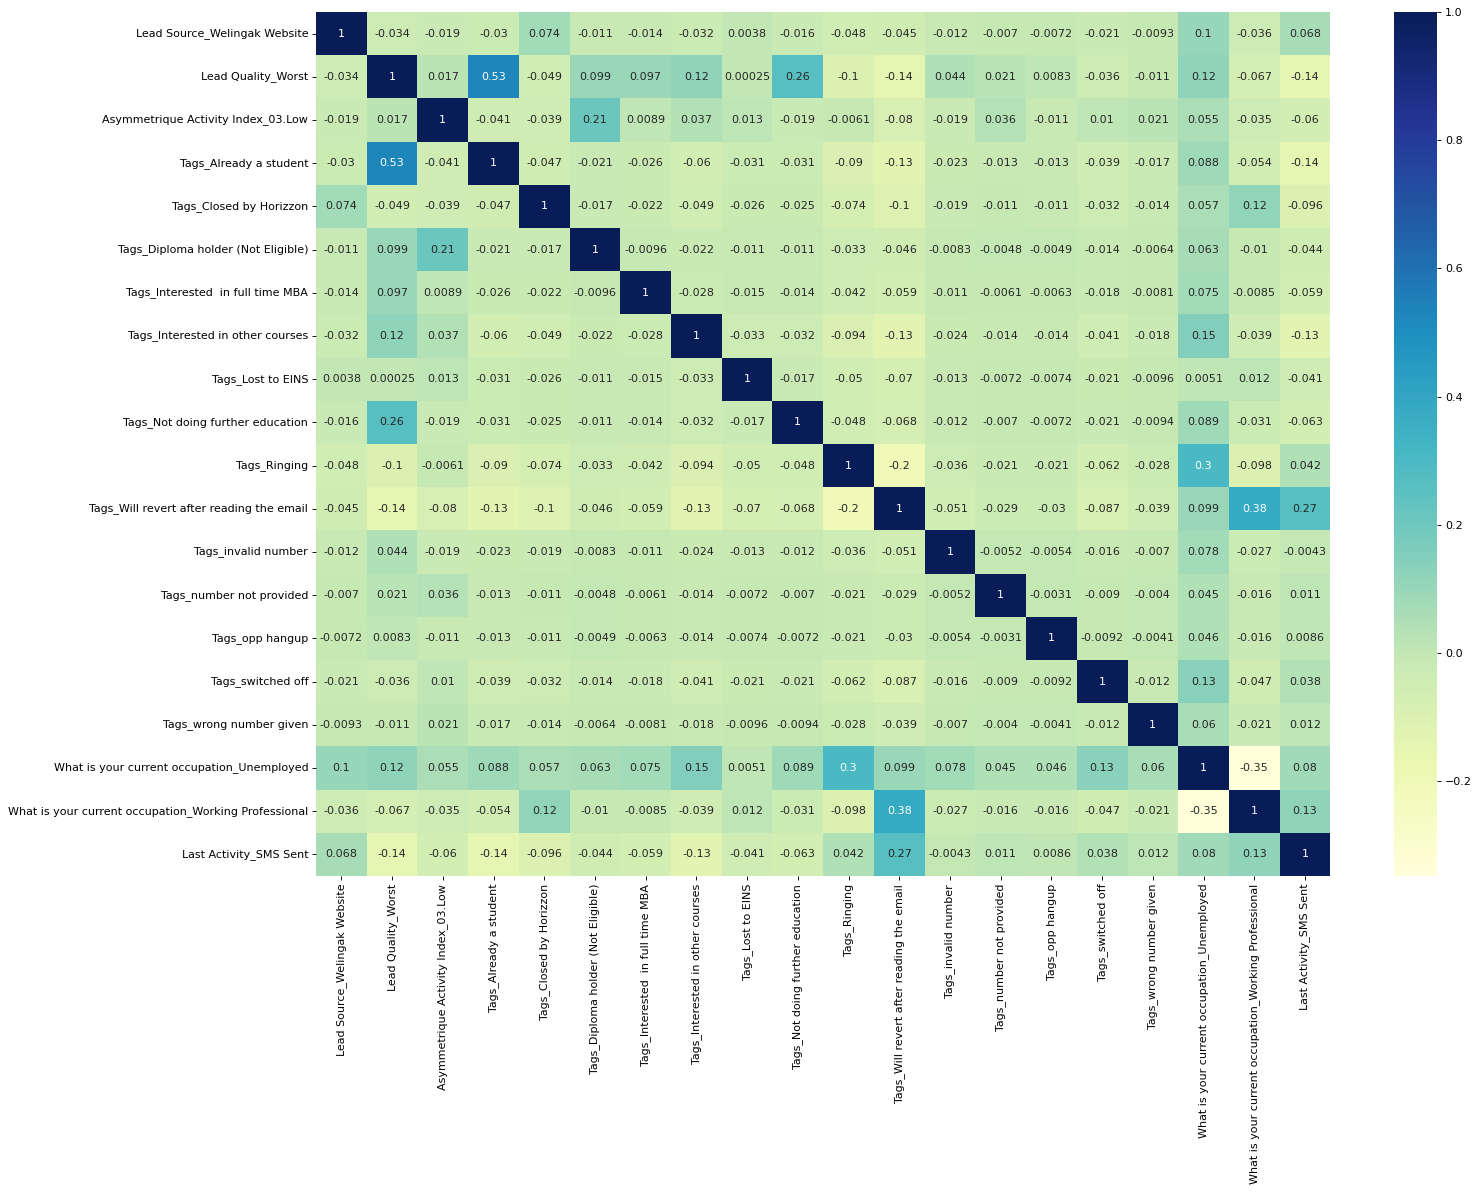

In [106]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(20,15), dpi=80, facecolor='w', edgecolor='k', frameon='True')

cor = X_train[col].corr()
sns.heatmap(cor, annot=True, cmap="YlGnBu")

plt.tight_layout()
plt.show()

### Dropping the Variable and Updating the Model

As you can notice some of the variable have high VIF values as well as high p-values. Such variables are insignificant and should be dropped.

In [107]:
col = col.drop('Tags_number not provided', 1)
col

Index(['Lead Source_Welingak Website', 'Lead Quality_Worst',
       'Asymmetrique Activity Index_03.Low', 'Tags_Already a student',
       'Tags_Closed by Horizzon', 'Tags_Diploma holder (Not Eligible)',
       'Tags_Interested  in full time MBA', 'Tags_Interested in other courses',
       'Tags_Lost to EINS', 'Tags_Not doing further education', 'Tags_Ringing',
       'Tags_Will revert after reading the email', 'Tags_invalid number',
       'Tags_opp hangup', 'Tags_switched off', 'Tags_wrong number given',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional',
       'Last Activity_SMS Sent'],
      dtype='object')

In [108]:
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6002
Model:                            GLM   Df Residuals:                     5982
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1278.7
Date:                Sun, 14 May 2023   Deviance:                       2557.4
Time:                        22:40:25   Pearson chi2:                 8.49e+03
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.4804      0.089    -27.881      0.000      -2.655      -2.306
Lead Source_Welingak Website                             3.2918      0.731      4.503      0.000       1.859       4.725
Lead Quality_Worst                                      -2.7112      0.739     -3.668      0.000      -4.160      -1.263
Asymmetrique Activity Index_03.Low                      -2.4342      0.357     -6.817      0.000      -3.134      -1.734
Tags_Already a student                                  -3.8015      0.724     -5.247      0.000      -5.221      -2.382
Tags_Closed by Horizzon                                  5.1851      0.722      7.184      0.000       3.770       6.600
Tags_Diploma holder (Not Eligible)                     -24.1120   2.81e+04     -0.001      0.999   -5.51e+04    5.51e+04
Tags_Interested  in full time MBA                       -2.9855      0.741     -4.028      0.000      -4.438      -1.533
Tags_Interested in other courses                        -2.9603      0.329     -8.996      0.000      -3.605      -2.315
Tags_Lost to EINS                                        6.4382      0.838      7.684      0.000       4.796       8.080
Tags_Not doing further education                        -3.7070      1.031     -3.596      0.000      -5.727      -1.687
Tags_Ringing                                            -4.1829      0.248    -16.855      0.000      -4.669      -3.696
Tags_Will revert after reading the email                 3.6368      0.193     18.834      0.000       3.258       4.015
Tags_invalid number                                    -25.6348    2.7e+04     -0.001      0.999    -5.3e+04    5.29e+04
Tags_opp hangup                                         -3.4305      1.062     -3.231      0.001      -5.512      -1.349
Tags_switched off                                       -5.0770      0.724     -7.013      0.000      -6.496      -3.658
Tags_wrong number given                                -26.0375   3.49e+04     -0.001      0.999   -6.85e+04    6.84e+04
What is your current occupation_Unemployed               1.9949      0.118     16.969      0.000       1.764       2.225
What is your current occupation_Working Professional     2.1030      0.363      5.788      0.000       1.391       2.815
Last Activity_SMS Sent                                   2.0063      0.111     18.069      0.000       1.789       2.224
========================================================================================================================
"""

In [109]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

8529    0.065249
7331    0.009300
7688    0.820658
92      0.077242
4908    0.077242
451     0.009300
4945    0.009300
2844    0.994861
4355    0.077242
7251    0.000913
dtype: float64

In [110]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([6.52492255e-02, 9.29987842e-03, 8.20658174e-01, 7.72422324e-02,
       7.72422324e-02, 9.29987842e-03, 9.29987842e-03, 9.94861183e-01,
       7.72422324e-02, 9.12704851e-04])

##### Creating a dataframe with the actual churn flag and the predicted probabilities

In [111]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final['LeadID'] = y_train.index
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID
0,0,0.065249,8529
1,0,0.009300,7331
2,1,0.820658,7688
3,0,0.077242,92
4,0,0.077242,4908


##### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [112]:
y_train_pred_final['predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID,predicted
0,0,0.065249,8529,0
1,0,0.009300,7331,0
2,1,0.820658,7688,1
3,0,0.077242,92,0
4,0,0.077242,4908,0


In [113]:
from sklearn import metrics

In [114]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[3641   95]
 [ 409 1857]]


In [115]:
# Predicted     not_churn    churn
# Actual
# not_churn        3270      365
# churn            579       708  

In [116]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.9160279906697767


#### Checking VIFs

In [117]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [118]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,Tags_Closed by Horizzon,1.29
9,Tags_Not doing further education,1.27
14,Tags_switched off,1.19
6,Tags_Interested in full time MBA,1.12
5,Tags_Diploma holder (Not Eligible),1.12
2,Asymmetrique Activity Index_03.Low,1.11
0,Lead Source_Welingak Website,1.09
12,Tags_invalid number,1.08
8,Tags_Lost to EINS,1.07
15,Tags_wrong number given,1.04


### Dropping the Variable and Updating the Model

As you can notice some of the variable have high VIF values as well as high p-values. Such variables are insignificant and should be dropped.

In [119]:
col = col.drop('Tags_wrong number given', 1)
col

Index(['Lead Source_Welingak Website', 'Lead Quality_Worst',
       'Asymmetrique Activity Index_03.Low', 'Tags_Already a student',
       'Tags_Closed by Horizzon', 'Tags_Diploma holder (Not Eligible)',
       'Tags_Interested  in full time MBA', 'Tags_Interested in other courses',
       'Tags_Lost to EINS', 'Tags_Not doing further education', 'Tags_Ringing',
       'Tags_Will revert after reading the email', 'Tags_invalid number',
       'Tags_opp hangup', 'Tags_switched off',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional',
       'Last Activity_SMS Sent'],
      dtype='object')

In [120]:
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6002
Model:                            GLM   Df Residuals:                     5983
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1305.1
Date:                Sun, 14 May 2023   Deviance:                       2610.1
Time:                        22:40:44   Pearson chi2:                 8.25e+03
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.4653      0.088    -27.969      0.000      -2.638      -2.293
Lead Source_Welingak Website                             3.4161      0.731      4.676      0.000       1.984       4.848
Lead Quality_Worst                                      -2.7568      0.728     -3.787      0.000      -4.184      -1.330
Asymmetrique Activity Index_03.Low                      -2.3688      0.357     -6.637      0.000      -3.068      -1.669
Tags_Already a student                                  -3.6760      0.724     -5.080      0.000      -5.094      -2.258
Tags_Closed by Horizzon                                  5.2742      0.721      7.314      0.000       3.861       6.687
Tags_Diploma holder (Not Eligible)                     -22.9881   1.71e+04     -0.001      0.999   -3.35e+04    3.35e+04
Tags_Interested  in full time MBA                       -2.8602      0.740     -3.866      0.000      -4.310      -1.410
Tags_Interested in other courses                        -2.8332      0.328     -8.641      0.000      -3.476      -2.191
Tags_Lost to EINS                                        6.4558      0.839      7.692      0.000       4.811       8.101
Tags_Not doing further education                        -3.5698      1.030     -3.467      0.001      -5.588      -1.552
Tags_Ringing                                            -4.0320      0.246    -16.378      0.000      -4.515      -3.550
Tags_Will revert after reading the email                 3.7184      0.192     19.386      0.000       3.342       4.094
Tags_invalid number                                    -24.4886   1.64e+04     -0.001      0.999   -3.22e+04    3.21e+04
Tags_opp hangup                                         -3.2794      1.061     -3.092      0.002      -5.358      -1.201
Tags_switched off                                       -4.9237      0.723     -6.809      0.000      -6.341      -3.506
What is your current occupation_Unemployed               1.8623      0.115     16.189      0.000       1.637       2.088
What is your current occupation_Working Professional     2.0226      0.363      5.570      0.000       1.311       2.734
Last Activity_SMS Sent                                   1.9628      0.109     17.982      0.000       1.749       2.177
========================================================================================================================
"""

In [121]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

8529    0.064635
7331    0.009613
7688    0.795734
92      0.078329
4908    0.078329
451     0.009613
4945    0.009613
2844    0.994720
4355    0.078329
7251    0.000879
dtype: float64

In [122]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([6.46349739e-02, 9.61261677e-03, 7.95733870e-01, 7.83285731e-02,
       7.83285731e-02, 9.61261677e-03, 9.61261677e-03, 9.94720023e-01,
       7.83285731e-02, 8.79091579e-04])

##### Creating a dataframe with the actual churn flag and the predicted probabilities

In [123]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final['LeadID'] = y_train.index
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID
0,0,0.064635,8529
1,0,0.009613,7331
2,1,0.795734,7688
3,0,0.078329,92
4,0,0.078329,4908


##### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [124]:
y_train_pred_final['predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID,predicted
0,0,0.064635,8529,0
1,0,0.009613,7331,0
2,1,0.795734,7688,1
3,0,0.078329,92,0
4,0,0.078329,4908,0


In [125]:
from sklearn import metrics

In [126]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[3630  106]
 [ 409 1857]]


In [127]:
# Predicted     not_churn    churn
# Actual
# not_churn        3270      365
# churn            579       708  

In [128]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.9141952682439187


#### Checking VIFs

In [129]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [130]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,Tags_Closed by Horizzon,1.29
9,Tags_Not doing further education,1.26
14,Tags_switched off,1.19
6,Tags_Interested in full time MBA,1.12
5,Tags_Diploma holder (Not Eligible),1.12
2,Asymmetrique Activity Index_03.Low,1.11
0,Lead Source_Welingak Website,1.09
12,Tags_invalid number,1.08
8,Tags_Lost to EINS,1.06
13,Tags_opp hangup,1.02


### Dropping the Variable and Updating the Model

As you can notice some of the variable have high VIF values as well as high p-values. Such variables are insignificant and should be dropped.

In [131]:
col = col.drop('Tags_Diploma holder (Not Eligible)', 1)
col

Index(['Lead Source_Welingak Website', 'Lead Quality_Worst',
       'Asymmetrique Activity Index_03.Low', 'Tags_Already a student',
       'Tags_Closed by Horizzon', 'Tags_Interested  in full time MBA',
       'Tags_Interested in other courses', 'Tags_Lost to EINS',
       'Tags_Not doing further education', 'Tags_Ringing',
       'Tags_Will revert after reading the email', 'Tags_invalid number',
       'Tags_opp hangup', 'Tags_switched off',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional',
       'Last Activity_SMS Sent'],
      dtype='object')

In [132]:
X_train_sm = sm.add_constant(X_train[col])
logm5 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm5.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6002
Model:                            GLM   Df Residuals:                     5984
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1313.2
Date:                Sun, 14 May 2023   Deviance:                       2626.4
Time:                        22:40:57   Pearson chi2:                 8.42e+03
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.4750      0.088    -28.020      0.000      -2.648      -2.302
Lead Source_Welingak Website                             3.4678      0.731      4.747      0.000       2.036       4.900
Lead Quality_Worst                                      -2.8883      0.706     -4.092      0.000      -4.272      -1.505
Asymmetrique Activity Index_03.Low                      -2.4330      0.351     -6.931      0.000      -3.121      -1.745
Tags_Already a student                                  -3.6149      0.723     -4.999      0.000      -5.032      -2.198
Tags_Closed by Horizzon                                  5.3212      0.721      7.382      0.000       3.908       6.734
Tags_Interested  in full time MBA                       -2.8081      0.740     -3.794      0.000      -4.259      -1.357
Tags_Interested in other courses                        -2.7838      0.328     -8.493      0.000      -3.426      -2.141
Tags_Lost to EINS                                        6.5606      0.846      7.757      0.000       4.903       8.218
Tags_Not doing further education                        -3.5144      1.030     -3.412      0.001      -5.533      -1.496
Tags_Ringing                                            -3.9921      0.246    -16.235      0.000      -4.474      -3.510
Tags_Will revert after reading the email                 3.7631      0.192     19.646      0.000       3.388       4.138
Tags_invalid number                                    -24.4442   1.64e+04     -0.001      0.999   -3.22e+04    3.21e+04
Tags_opp hangup                                         -3.2379      1.061     -3.052      0.002      -5.317      -1.159
Tags_switched off                                       -4.8845      0.723     -6.756      0.000      -6.302      -3.467
What is your current occupation_Unemployed               1.8184      0.114     15.893      0.000       1.594       2.043
What is your current occupation_Working Professional     1.9876      0.362      5.486      0.000       1.277       2.698
Last Activity_SMS Sent                                   1.9808      0.109     18.198      0.000       1.767       2.194
========================================================================================================================
"""

In [133]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

8529    0.064888
7331    0.009483
7688    0.789866
92      0.077629
4908    0.077629
451     0.009483
4945    0.009483
2844    0.994813
4355    0.077629
7251    0.000777
dtype: float64

In [134]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([6.48878261e-02, 9.48266404e-03, 7.89866093e-01, 7.76292105e-02,
       7.76292105e-02, 9.48266404e-03, 9.48266404e-03, 9.94812863e-01,
       7.76292105e-02, 7.76508332e-04])

##### Creating a dataframe with the actual churn flag and the predicted probabilities

In [135]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final['LeadID'] = y_train.index
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID
0,0,0.064888,8529
1,0,0.009483,7331
2,1,0.789866,7688
3,0,0.077629,92
4,0,0.077629,4908


##### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [136]:
y_train_pred_final['predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID,predicted
0,0,0.064888,8529,0
1,0,0.009483,7331,0
2,1,0.789866,7688,1
3,0,0.077629,92,0
4,0,0.077629,4908,0


In [137]:
from sklearn import metrics

In [138]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[3629  107]
 [ 409 1857]]


In [139]:
# Predicted     not_churn    churn
# Actual
# not_churn        3270      365
# churn            579       708  

In [140]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.9140286571142953


#### Checking VIFs

In [141]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [142]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,Tags_Closed by Horizzon,1.28
8,Tags_Not doing further education,1.25
13,Tags_switched off,1.18
5,Tags_Interested in full time MBA,1.11
0,Lead Source_Welingak Website,1.08
11,Tags_invalid number,1.07
2,Asymmetrique Activity Index_03.Low,1.07
7,Tags_Lost to EINS,1.06
12,Tags_opp hangup,1.02
15,What is your current occupation_Working Profes...,0.78


### Dropping the Variable and Updating the Model

As you can notice some of the variable have high VIF values as well as high p-values. Such variables are insignificant and should be dropped.

In [143]:
col = col.drop('Tags_invalid number', 1)
col

Index(['Lead Source_Welingak Website', 'Lead Quality_Worst',
       'Asymmetrique Activity Index_03.Low', 'Tags_Already a student',
       'Tags_Closed by Horizzon', 'Tags_Interested  in full time MBA',
       'Tags_Interested in other courses', 'Tags_Lost to EINS',
       'Tags_Not doing further education', 'Tags_Ringing',
       'Tags_Will revert after reading the email', 'Tags_opp hangup',
       'Tags_switched off', 'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional',
       'Last Activity_SMS Sent'],
      dtype='object')

In [144]:
X_train_sm = sm.add_constant(X_train[col])
logm6 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm6.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6002
Model:                            GLM   Df Residuals:                     5985
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1342.4
Date:                Sun, 14 May 2023   Deviance:                       2684.8
Time:                        22:41:06   Pearson chi2:                 8.52e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -2.4751      0.088    -28.144      0.000      -2.647      -2.303
Lead Source_Welingak Website                             3.6135      0.730      4.949      0.000       2.182       5.044
Lead Quality_Worst                                      -3.1794      0.670     -4.742      0.000      -4.494      -1.865
Asymmetrique Activity Index_03.Low                      -2.3401      0.354     -6.605      0.000      -3.035      -1.646
Tags_Already a student                                  -3.4492      0.722     -4.776      0.000      -4.865      -2.034
Tags_Closed by Horizzon                                  5.4435      0.720      7.559      0.000       4.032       6.855
Tags_Interested  in full time MBA                       -2.6565      0.740     -3.591      0.000      -4.106      -1.207
Tags_Interested in other courses                        -2.6347      0.327     -8.060      0.000      -3.275      -1.994
Tags_Lost to EINS                                        6.7102      0.862      7.786      0.000       5.021       8.399
Tags_Not doing further education                        -3.3472      1.030     -3.250      0.001      -5.366      -1.329
Tags_Ringing                                            -3.8360      0.244    -15.709      0.000      -4.315      -3.357
Tags_Will revert after reading the email                 3.8695      0.190     20.331      0.000       3.497       4.243
Tags_opp hangup                                         -3.0789      1.061     -2.903      0.004      -5.158      -1.000
Tags_switched off                                       -4.7274      0.722     -6.544      0.000      -6.143      -3.311
What is your current occupation_Unemployed               1.6711      0.112     14.926      0.000       1.452       1.891
What is your current occupation_Working Professional     1.8944      0.363      5.221      0.000       1.183       2.606
Last Activity_SMS Sent                                   1.9687      0.107     18.383      0.000       1.759       2.179
========================================================================================================================
"""

In [145]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

8529    0.064688
7331    0.009566
7688    0.762190
92      0.077626
4908    0.077626
451     0.009566
4945    0.009566
2844    0.994819
4355    0.077626
7251    0.000591
dtype: float64

In [146]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([6.46881585e-02, 9.56568869e-03, 7.62190244e-01, 7.76256984e-02,
       7.76256984e-02, 9.56568869e-03, 9.56568869e-03, 9.94818870e-01,
       7.76256984e-02, 5.91337209e-04])

##### Creating a dataframe with the actual Converted flag and the predicted probabilities

In [147]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final['LeadID'] = y_train.index
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID
0,0,0.064688,8529
1,0,0.009566,7331
2,1,0.762190,7688
3,0,0.077626,92
4,0,0.077626,4908


##### Creating new column 'predicted' with 1 if Conversion_Prob > 0.5 else 0

In [148]:
y_train_pred_final['predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID,predicted
0,0,0.064688,8529,0
1,0,0.009566,7331,0
2,1,0.762190,7688,1
3,0,0.077626,92,0
4,0,0.077626,4908,0


In [149]:
from sklearn import metrics

In [150]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[3620  116]
 [ 409 1857]]


In [151]:
# Predicted     not_churn    churn
# Actual
# not_churn        3270      365
# churn            579       708  

In [152]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.9125291569476841


#### Checking VIFs

In [153]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [154]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,Tags_Closed by Horizzon,1.26
8,Tags_Not doing further education,1.23
12,Tags_switched off,1.17
5,Tags_Interested in full time MBA,1.10
0,Lead Source_Welingak Website,1.08
2,Asymmetrique Activity Index_03.Low,1.07
7,Tags_Lost to EINS,1.06
11,Tags_opp hangup,1.02
14,What is your current occupation_Working Profes...,0.77
1,Lead Quality_Worst,0.67


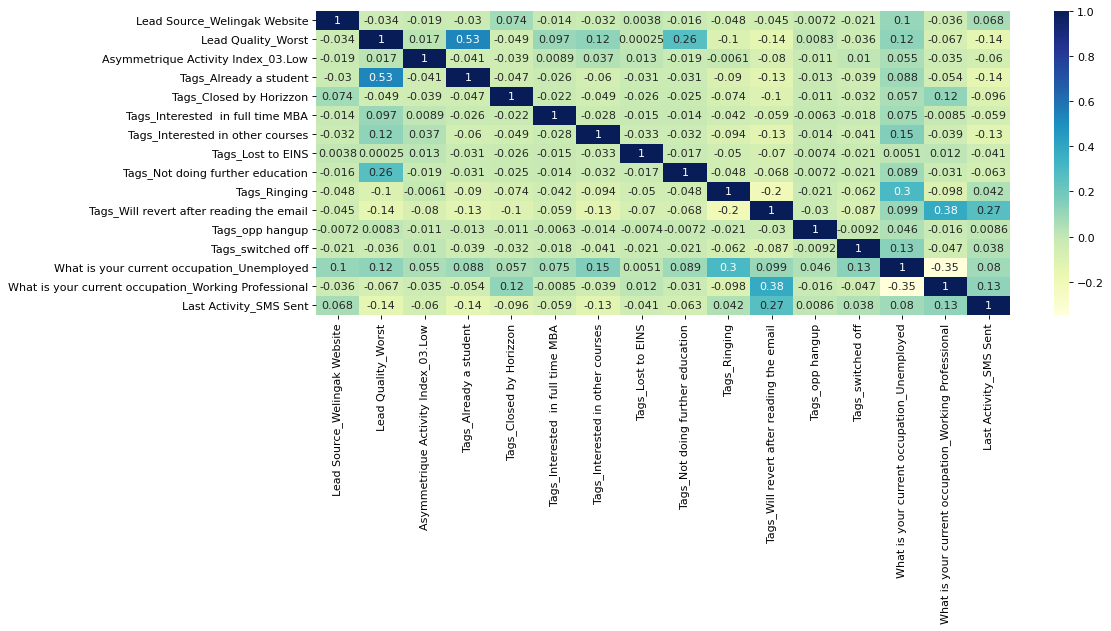

In [155]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(15,8), dpi=80, facecolor='w', edgecolor='k', frameon='True')

cor = X_train[col].corr()
sns.heatmap(cor, annot=True, cmap="YlGnBu")

plt.tight_layout()
plt.show()

### Our latest model have the following features:
 - <font color = blue>All variables have p-value < 0.05. </font>
 - <font color = blue>All the features have very low VIF values, meaning, there is hardly any muliticollinearity among the features. This is also evident from the heat map.</font>
 - <font color = blue>The overall accuracy of `0.9125` at a probability threshold of 0.05 is also very acceptable.</font>
 
### So we need not drop any more variables and we can proceed with making predictions using this model only

## Step 8: Calculating Metrics beyond Accuracy

In [156]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [157]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8195057369814651

In [158]:
# Let us calculate specificity
TN / float(TN+FP)

0.9689507494646681

In [159]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.031049250535331904


In [160]:
# positive predictive value 
print (TP / float(TP+FP))

0.941206284845413


In [161]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8984859766691486


## Step 9: Plotting the ROC Curve

An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [162]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr,tpr, thresholds

In [163]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob, drop_intermediate = False )

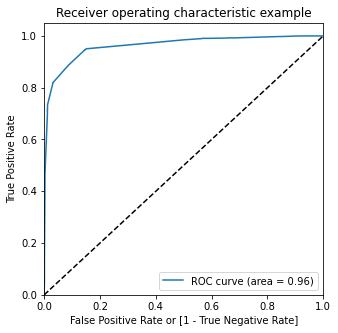

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.67665953e-04,
        2.67665953e-04, 2.67665953e-04, 5.35331906e-04, 8.02997859e-04,
        8.02997859e-04, 2.14132762e-03, 2.14132762e-03, 2.40899358e-03,
        2.40899358e-03, 2.67665953e-03, 2.67665953e-03, 2.67665953e-03,
        2.67665953e-03, 2.67665953e-03, 4.55032120e-03, 1.15096360e-02,
        1.15096360e-02, 1.15096360e-02, 1.15096360e-02, 1.15096360e-02,
        1.15096360e-02, 1.17773019e-02, 1.17773019e-02, 1.20449679e-02,
        1.20449679e-02, 3.07815846e-02, 3.07815846e-02, 3.07815846e-02,
        3.10492505e-02, 3.10492505e-02, 3.13169165e-02, 8.61884368e-02,
        8.69914347e-02, 1.45610278e-01, 1.45610278e-01, 1.45877944e-01,
        1.48019272e-01, 1.48019272e-01, 1.51498929e-01, 1.52301927e-01,
        1.53640257e-01, 1.55513919e-01, 1.56584582e-01, 1.573875

In [164]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

### Calculating the area under the curve(GINI)

In [165]:
def auc_val(fpr,tpr):
    AreaUnderCurve = 0.
    for i in range(len(fpr)-1):
        AreaUnderCurve += (fpr[i+1]-fpr[i]) * (tpr[i+1]+tpr[i])
    AreaUnderCurve *= 0.5
    return AreaUnderCurve

In [166]:
auc = auc_val(fpr,tpr)
auc

0.9623860234430959

## Step 10: Finding Optimal Cutoff Point

Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [167]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.064688,8529,0,1,0,0,0,0,0,0,0,0,0
1,0,0.009566,7331,0,1,0,0,0,0,0,0,0,0,0
2,1,0.762190,7688,1,1,1,1,1,1,1,1,1,0,0
3,0,0.077626,92,0,1,0,0,0,0,0,0,0,0,0
4,0,0.077626,4908,0,1,0,0,0,0,0,0,0,0,0


In [168]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.377541  1.000000  0.000000
0.1   0.1  0.884039  0.951015  0.843415
0.2   0.2  0.888204  0.947926  0.851981
0.3   0.3  0.889037  0.946161  0.854390
0.4   0.4  0.912363  0.819506  0.968683
0.5   0.5  0.912529  0.819506  0.968951
0.6   0.6  0.912363  0.819064  0.968951
0.7   0.7  0.911863  0.817299  0.969218
0.8   0.8  0.892203  0.734334  0.987955
0.9   0.9  0.885205  0.715357  0.988223


### Let's plot accuracy sensitivity and specificity for various probabilities.


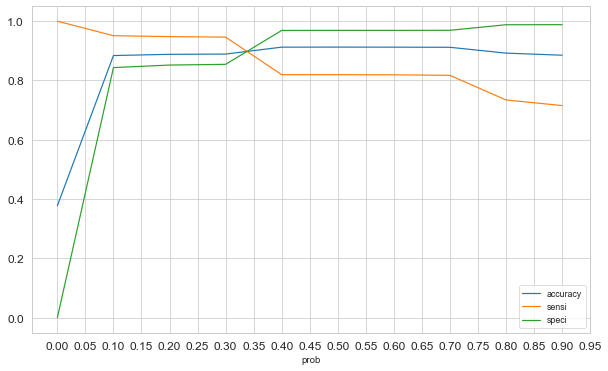

In [169]:
# Slightly alter the figure size to make it more horizontal.

#plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("whitegrid") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'], figsize=(10,6))
# plot x axis limits
plt.xticks(np.arange(0, 1, step=0.05), size = 12)
plt.yticks(size = 12)
plt.show()

#### From the curve above, 0.33 is the optimum point to take it as a cutoff probability.

In [170]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map( lambda x: 1 if x > 0.33 else 0)

y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.064688,8529,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0.009566,7331,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0.762190,7688,1,1,1,1,1,1,1,1,1,0,0,1
3,0,0.077626,92,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0.077626,4908,0,1,0,0,0,0,0,0,0,0,0,0


In [171]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.9031989336887704

In [172]:
confusion1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted)
confusion1

array([[3411,  325],
       [ 256, 2010]], dtype=int64)

In [173]:
TP = confusion1[1,1] # true positive 
TN = confusion1[0,0] # true negatives
FP = confusion1[0,1] # false positives
FN = confusion1[1,0] # false negatives

In [174]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8870255957634599

In [175]:
# Let us calculate specificity
TN / float(TN+FP)

0.9130085653104925

In [176]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.0869914346895075


In [177]:
# Positive predictive value 
print (TP / float(TP+FP))

0.860813704496788


In [178]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9301881647122989


## Step 11: Precision and Recall

##### Precision
TP / TP + FP

In [179]:
precision = confusion1[1,1]/(confusion1[0,1]+confusion1[1,1])
precision

0.860813704496788

##### Recall
TP / TP + FN

In [180]:
recall = confusion1[1,1]/(confusion1[1,0]+confusion1[1,1])
recall

0.8870255957634599

Using sklearn utilities for the same

In [181]:
from sklearn.metrics import precision_score, recall_score

In [182]:
precision_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.860813704496788

In [183]:
recall_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.8870255957634599

### Precision and recall tradeoff

In [184]:
from sklearn.metrics import precision_recall_curve

In [185]:
y_train_pred_final.Converted, y_train_pred_final.final_predicted

(0       0
 1       0
 2       1
 3       0
 4       0
        ..
 5997    0
 5998    0
 5999    0
 6000    1
 6001    0
 Name: Converted, Length: 6002, dtype: int64,
 0       0
 1       0
 2       1
 3       0
 4       0
        ..
 5997    0
 5998    0
 5999    0
 6000    1
 6001    0
 Name: final_predicted, Length: 6002, dtype: int64)

In [186]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

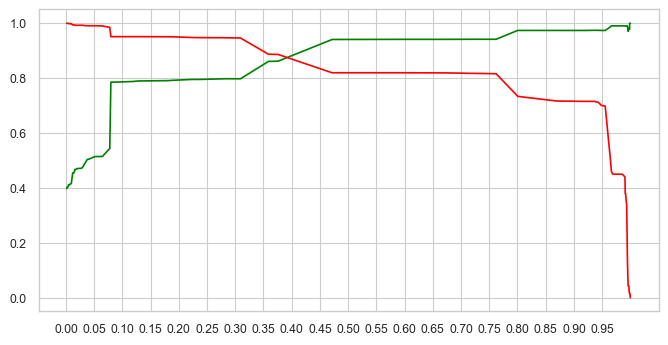

In [187]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(8, 4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.xticks(np.arange(0, 1, step=0.05))
plt.show()

#### From the precision-recall graph above, we get the optical threshold value as close to .37. However our business requirement here is to have Lead Conversion Rate around 80%.  

#### This is already achieved with our earlier threshold value of 0.33. So we will stick to this value.

### Calculating the F1 score
##### F1 = 2×(Precision*Recall)/(Precision+Recall)

In [188]:
F1 = 2*(precision*recall)/(precision+recall)
F1

0.8737231036731146

## Step 12: Making predictions on the test set

#### Using the scaler function from the train dataset to transfor the test dataset

In [189]:
X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.transform(X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])
X_test.head()

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,...,Last Activity_Form Submitted on Website,Last Activity_Had a Phone Conversation,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_Resubscribed to emails,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow
6190,0,0,-1.199737,-0.872062,-1.270553,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7073,0,0,0.969969,-0.615211,1.785283,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4519,1,0,-1.199737,-0.872062,-1.270553,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
607,0,0,-1.199737,-0.872062,-1.270553,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
440,0,0,1.403911,-0.094170,0.562949,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [190]:
X_test = X_test[col]
X_test.head()

,Lead Source_Welingak Website,Lead Quality_Worst,Asymmetrique Activity Index_03.Low,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Ringing,Tags_Will revert after reading the email,Tags_opp hangup,Tags_switched off,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Last Activity_SMS Sent
6190,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
7073,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4519,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
607,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
440,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Adding the constant

In [191]:
X_test_sm = sm.add_constant(X_test)

Making predictions on the test set

In [192]:
y_test_pred = res.predict(X_test_sm)

In [193]:
y_test_pred[:10]

6190    0.000591
7073    0.077626
4519    0.309185
607     0.999825
440     0.077626
4247    0.077626
7431    0.008041
726     0.376039
7300    0.008041
4046    0.077626
dtype: float64

In [194]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [195]:
# Let's see the head
y_pred_1.head()

,0
6190,0.000591
7073,0.077626
4519,0.309185
607,0.999825
440,0.077626


In [196]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [197]:
# Putting CustID to index
y_test_df['LeadID'] = y_test_df.index

In [198]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [199]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [200]:
y_pred_final.head()

,Converted,LeadID,0
0,0,6190,0.000591
1,0,7073,0.077626
2,0,4519,0.309185
3,1,607,0.999825
4,0,440,0.077626


In [201]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Conversion_Prob'})

In [202]:
# Rearranging the columns
y_pred_final = y_pred_final.reindex_axis(['LeadID','Converted','Conversion_Prob'], axis=1)

AttributeError: 'DataFrame' object has no attribute 'reindex_axis'

In [ ]:
# Let's see the head of y_pred_final
y_pred_final.head()

In [ ]:
y_pred_final.shape

#### Using the probability threshold value 0f 0.33 on the test dataset to predict if a lead will convert

In [ ]:
y_pred_final['final_predicted'] = y_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.33 else 0)

In [ ]:
y_pred_final.head()

In [ ]:
# Let's check the overall accuracy.
acc_score=metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_predicted)
acc_score

In [ ]:
confusion_test = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_predicted )
print(confusion_test)

### Confusion Matrix in Visuals

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=confusion_test)
all_sample_title = 'Accuracy Score: {0}'.format(acc_score)
plt.title(all_sample_title, size = 12);
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

In [ ]:
TP = confusion_test[1,1] # true positive 
TN = confusion_test[0,0] # true negatives
FP = confusion_test[0,1] # false positives
FN = confusion_test[1,0] # false negatives

#### Showcasing the different metrics beyond accuracy on the test dataset

##### Sensitivity
TP / TP + FN

In [ ]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

##### Specificity
TN / TN + FP

In [ ]:
# Let us calculate specificity
TN / float(TN+FP)

##### False Postive Rate
FP / TN + FP

In [ ]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

##### Positive Predictive Value
TP / TP + FP

In [ ]:
# Positive predictive value 
print (TP / float(TP+FP))

##### Negative Predictive Value
TN / TN + FN

In [ ]:
# Negative predictive value
print (TN / float(TN+ FN))

##### Precision
TP / TP + FP

In [ ]:
Precision = confusion_test[1,1]/(confusion_test[0,1]+confusion_test[1,1])
Precision

##### Recall
TP / TP + FN

In [ ]:
Recall = confusion_test[1,1]/(confusion_test[1,0]+confusion_test[1,1])
Recall

##### F1 = 2×(Precision*Recall)/(Precision+Recall)

In [ ]:
F1 = 2*(Precision*Recall)/(Precision+Recall)
F1

##### Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_final.Converted, y_pred_final.final_predicted))

##### Cross Validation Score

#### To avoid overfitting, let us calculate the Cross Validation Score to see how our model performs

In [ ]:
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(solver = 'lbfgs')
scores = cross_val_score(lr, X, y, cv=10)
scores.sort()
accuracy = scores.mean()

print(scores)
print(accuracy)

### Plotting the ROC Curve for Test Dataset

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr,tpr, thresholds

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve( y_pred_final.Converted, y_pred_final.Conversion_Prob, drop_intermediate = False )

In [ ]:
draw_roc(y_pred_final.Converted, y_pred_final.Conversion_Prob)

### Calculating the Area Under the Curve(GINI)

In [ ]:
def auc_val(fpr,tpr):
    AreaUnderCurve = 0.
    for i in range(len(fpr)-1):
        AreaUnderCurve += (fpr[i+1]-fpr[i]) * (tpr[i+1]+tpr[i])
    AreaUnderCurve *= 0.5
    return AreaUnderCurve

In [ ]:
auc = auc_val(fpr,tpr)
auc

***As a rule of thumb, an AUC can be classed as follows,***

 - 0.90 - 1.00 = excellent
 - 0.80 - 0.90 = good
 - 0.70 - 0.80 = fair
 - 0.60 - 0.70 = poor
 - 0.50 - 0.60 = fail
 
***Since we got a value of 0.9678, our model seems to be doing well on the test dataset.***

## Step 13: Calculating Lead score for the entire dataset

### Lead Score = 100 * ConversionProbability

#### This needs to be calculated for all the leads from the original dataset (train + test)

In [ ]:
# Selecting the test dataset along with the Conversion Probability and final predicted value for 'Converted'
leads_test_pred = y_pred_final.copy()
leads_test_pred.head()

In [ ]:
# Selecting the train dataset along with the Conversion Probability and final predicted value for 'Converted'
leads_train_pred = y_train_pred_final.copy()
leads_train_pred.head()

In [ ]:
# Dropping unnecessary columns from train dataset
leads_train_pred = leads_train_pred[['LeadID','Converted','Conversion_Prob','final_predicted']]
leads_train_pred.head()

### Concatenating the train and the test dataset with the Conversion Probabilities

In [ ]:
# Concatenating the 2 dataframes train and test along the rows with the append() function
lead_full_pred = leads_train_pred.append(leads_test_pred)
lead_full_pred.head()

In [ ]:
# Inspecting the shape of the final dataframe and the test and train dataframes
print(leads_train_pred.shape)
print(leads_test_pred.shape)
print(lead_full_pred.shape)

In [ ]:
# Ensuring the LeadIDs are unique for each lead in the finl dataframe
len(lead_full_pred['LeadID'].unique().tolist())

In [ ]:
# Calculating the Lead Score value
# Lead Score = 100 * Conversion_Prob
lead_full_pred['Lead_Score'] = lead_full_pred['Conversion_Prob'].apply(lambda x : round(x*100))
lead_full_pred.head()

In [ ]:
# Inspecing the max LeadID
lead_full_pred.LeadID.max()

In [ ]:
# Making the LeadID column as index
# We willlater join it with the original_leads dataframe based on index
lead_full_pred = lead_full_pred.set_index('LeadID').sort_index(axis = 0, ascending = True)
lead_full_pred.head()

In [ ]:
# Slicing the Lead Number column from original_leads dataframe
original_leads = original_leads[['Lead Number']]
original_leads.head()

#### Concatenating the 2 dataframes based on index.
#### This is done so that Lead Score is associated to the Lead Number of each Lead. This will help in quick identification of the lead.


In [ ]:
# Concatenating the 2 dataframes based on index and displaying the top 10 rows
# This is done son that Lead Score is associated to the Lead Number of each Lead. This will help in quick identification of the lead.
leads_with_score = pd.concat([original_leads, lead_full_pred], axis=1)
leads_with_score.head(10)

In [ ]:
# Inspecting the dataframe shape
leads_with_score.shape

In [ ]:
# Inspectin if the final dataframe has any null values

total = pd.DataFrame(leads_with_score.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(leads_with_score.isnull().sum()/leads_with_score.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])
pd.concat([total, percentage], axis = 1)

## Step 14: Determining Feature Importance

#### Selecting the coefficients of the selected features from our final model excluding the intercept

In [ ]:
pd.options.display.float_format = '{:.2f}'.format
new_params = res.params[1:]
new_params

#### Getting a relative coeffient value for all the features wrt the feature with the highest coefficient

In [ ]:
#feature_importance = abs(new_params)
feature_importance = new_params
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_importance

#### Sorting the feature variables based on their relative coefficient values

In [ ]:
sorted_idx = np.argsort(feature_importance,kind='quicksort',order='list of str')
sorted_idx
##

#### Plot showing the feature variables based on their relative coefficient values

In [ ]:
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,6))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center', color = 'tab:red',alpha=0.8)
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train[col].columns)[sorted_idx], fontsize=12)
featax.set_xlabel('Relative Feature Importance', fontsize=14)

plt.tight_layout()   
plt.show()

### Selecting `Top 3` features which contribute most towards the probability of a lead getting converted

In [ ]:
pd.DataFrame(feature_importance).reset_index().sort_values(by=0,ascending=False).head(3)

## Step 15: Conclusion

### After trying several models, we finally chose a model with the following characteristics:

 - <font color = blue>All variables have p-value < `0.05`. </font>
 - <font color = blue>All the features have very low VIF values, meaning, there is `hardly any muliticollinearity` among the features. This is also evident from the heat map.</font>
 - <font color = blue>The overall accuracy of `0.9056` at a probability threshold of 0.33 on the test dataset is also very acceptable.</font>
    
#### Using this model, the dependent variable value was predicted as per the following threshold values of Conversion probability:

|Dataset|Threshhold value|Accuracy|Sensitivity|Specificity|False Postive Rate|Positive Predictive Value|Negative Predictive value|Precision|Recall|F1 value|Cross Validation Score|AUC|
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|train|0.50|<font color = red>0.9125</font>|0.8195|<font color = red>0.9690</font>|0.0310|<font color = red>0.9412</font>|0.8985|||||0.9624|
|train|0.33|0.9032|<font color = red>0.8870</font>|0.9130|<font color = red>0.0870</font>|0.8608|<font color = red>0.9302</font>|0.8608|0.8870|0.8737||0.9624|
|<font color = blue>test</font>|<font color = blue>0.33</font>|<font color = blue>0.9056</font>|<font color = blue>0.8886</font>|<font color = blue>0.9163</font>|<font color = blue>0.0837</font>|<font color = blue>0.8702</font>|<font color = blue>0.9287</font>|<font color = blue>0.8702</font>|<font color = blue>0.8886</font>|<font color = blue>0.8793</font>|<font color = blue>0.9123</font>|<font color = blue>0.9679</font>|

### Based on our model, some features are identified which contribute most to a Lead getting converted successfully. 


#### The conversion probability of a lead increases with increase in values of the following features in descending order:

|Features with Positive Coefficient Values|
|-------------|
|Tags_Lost to EINS|
|Tags_Closed by Horizzon|
|Tags_Will revert after reading the email|
|Lead Source_Welingak Website|
|Last Activity_SMS Sent|
|What is your current occupation_Working Professional|
|What is your current occupation_Unemployed|

#### The conversion probability of a lead increases with decrease in values of the following features in descending order:

|Features with Negative Coefficient Values|
|----------|
|Tags_switched off|
|Tags_Ringing|
|Tags_Already a student|
|Tags_Not doing further education|
|Lead Quality_Worst|
|Tags_opp hangup|
|Tags_Interested  in full time MBA|
|Tags_Interested in other courses|
|Asymmetrique Activity Index_03.Low|


*** Another point to note here is that, depending on the business requirement, we can increase or decrease the probability threshold value with in turn will decrease or increase the Sensitivity and increase or decrease the Specificity of the model. ***

*** High Sensitivity will ensure that almost all leads who are likely to Convert are correctly predicted where as high Specificity will ensure that leads that are on the brink of the probability of getting Converted or not are not selected. ***